### Домашнее задание "Модели авторегрессии условной гетероскедантичности"

- Выберите ряд и постройте его модель GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from arch import arch_model
import matplotlib.pyplot as plt
%matplotlib inline

Вспомогательные функции

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

А предыдущем ДЗ я анализировала ряд со значениями индекса Доу-Джонса. Для разнообразия возьму что-нибудь другое, например, данные о рождаемости девочек

In [3]:
ts = pd.read_csv("Series/daily-total-female-births-in-cal.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


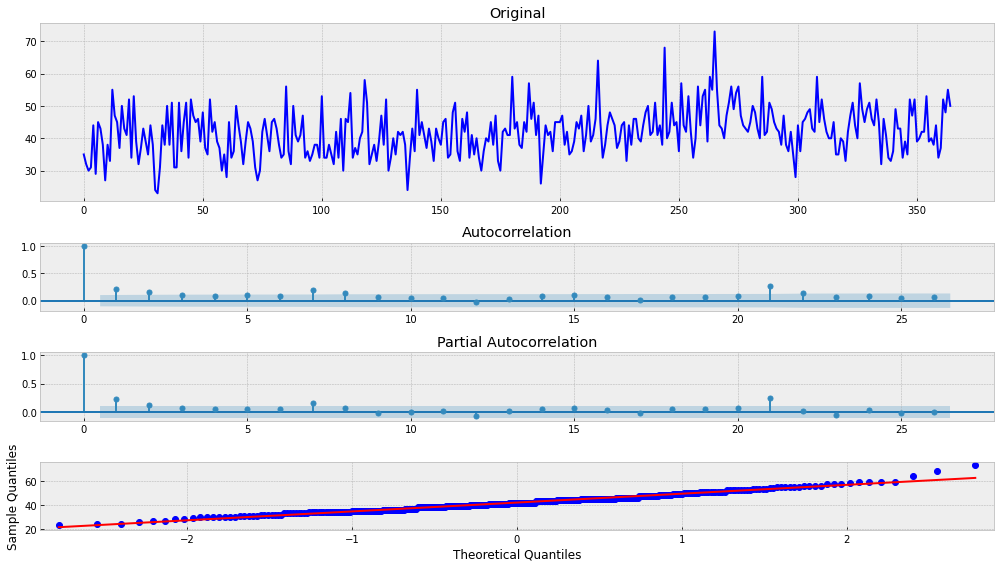

In [4]:
tsplot(ts)

Изначально этот ряд по своему виду и ниизкому значению p-value очень близок к стационарному. 
Для начала применим модель ARIMA к ряду, чтобы подобрать наилучшие параметры

In [43]:
import warnings
warnings.simplefilter('ignore')

In [6]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(ts)

aic: 2452.90316 | order: (3, 1, 4)


Найденные оптимальные значения i, d и j не являются максимальными из рассматриваемых, значит искать их дальше среди значений >=5 не нужно 

Results of Dickey-Fuller Test:
Test Statistic                -1.821395e+01
p-value                        2.388903e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.630000e+02
Critical Value (1%)           -3.448494e+00
Critical Value (5%)           -2.869535e+00
Critical Value (10%)          -2.571029e+00
dtype: float64


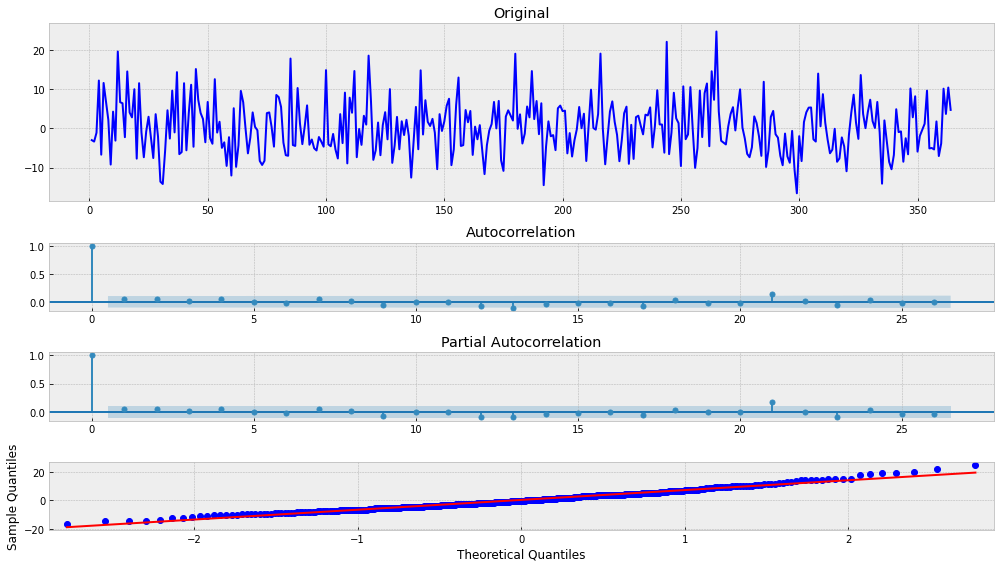

In [7]:
tsplot(mdl.resid)

Распределение остатков близко к нормальному распределению

Построим модель GARCH, применив параметры из ARIMA

In [20]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(ts, p=p_, o=o_, q=q_, dist='StudentsT',vol='GARCH')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     72,   Neg. LLF: 1242.5634450139596
Iteration:     10,   Func. Count:    138,   Neg. LLF: 1241.5239293136324
Iteration:     15,   Func. Count:    203,   Neg. LLF: 1241.4738466229105
Iteration:     20,   Func. Count:    270,   Neg. LLF: 1241.36027783578
Iteration:     25,   Func. Count:    335,   Neg. LLF: 1241.3542072316563
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1241.3522892608291
            Iterations: 28
            Function evaluations: 375
            Gradient evaluations: 28
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Count   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1241.35
Distribution:      Standardized Student's t   AIC:                           2504.70


Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


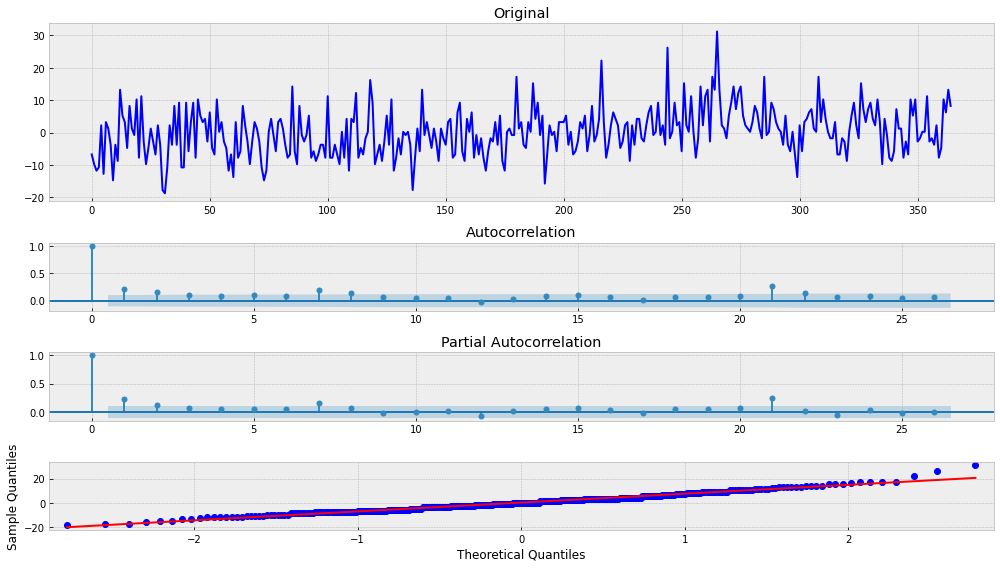

In [21]:
tsplot(res.resid)

Можно сказать, что распределение остатков носит случайный характер (хотя есть несколько отклонений, особенно заметных в правой части q-q графика)

Для того, чтобы посмотреть прогнозные значения дисперсии, предсказанные моделью, разделим выборку на трейн и тест, переобучим модель на трейне и посмотрим на прогноз по тесту

In [75]:
n_test = int(0.15*len(ts))

In [77]:
train, test = ts[: -n_test], ts[-n_test:]

In [78]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(train, p=p_, o=o_, q=q_, dist='StudentsT',vol='GARCH')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     72,   Neg. LLF: 1064.1648899635363
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1062.9897636223286
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1062.931486097097
Iteration:     20,   Func. Count:    271,   Neg. LLF: 1062.9275032411401
Iteration:     25,   Func. Count:    336,   Neg. LLF: 1062.926857480838
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1062.92684222018
            Iterations: 26
            Function evaluations: 350
            Gradient evaluations: 26
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Count   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1062.93
Distribution:      Standardized Student's t   AIC:                           2147.85
Me

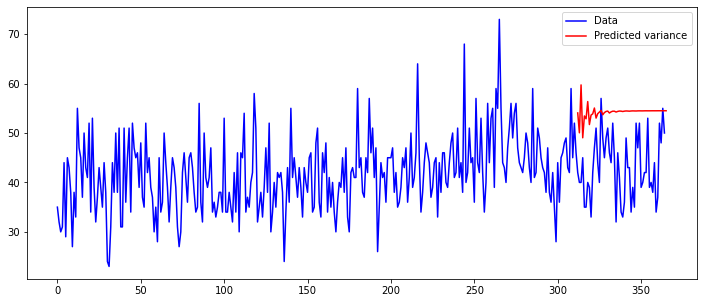

In [108]:
yhat = model_fit.forecast(horizon=n_test)


plt.figure(figsize=(12, 5))
plt.plot(ts, color='blue', label='Data')
forecast = yhat.variance.values[-1, :]
plt.plot(range(len(train)+1, len(ts)+1), forecast, color='red', label='Predicted variance')
plt.legend()


#### С помощью ML

In [87]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15, col_name='Count'):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data[col_name].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
#     data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([col_name], axis=1)
    y_train = data.loc[:test_index][col_name]
    X_test = data.loc[test_index:].drop([col_name], axis=1)
    y_test = data.loc[test_index:][col_name]
    
    return X_train, X_test, y_train, y_test

In [101]:
X_train, X_test, y_train, y_test = prepareData(ts, lag_start=1, lag_end=20, test_size=0.2)

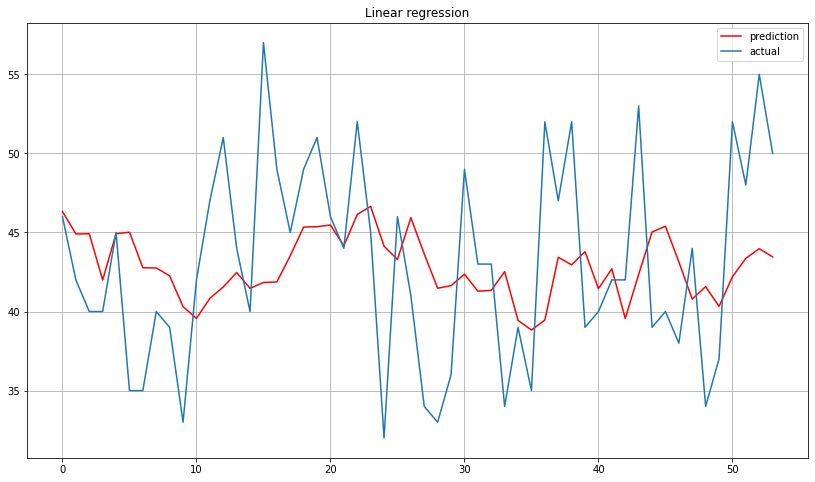

In [102]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

Обычная линейная регрессия не попала в исходный ряд.
Попробую использовать какой-нибудь другой регрессор с различными параметрами в поисках лучшего результата

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [104]:
parameters = {'n_estimators':[20, 50, 80, 100, 120], 
              'max_depth':np.arange(1,11), 
              'min_samples_split':np.arange(2,10), 
              'min_samples_leaf':np.arange(1,5)}

In [105]:
tree_grid = GridSearchCV(RandomForestRegressor(), parameters, cv = 5, n_jobs=-1)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_leaf': array([1, 2, 3, 4]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': [20, 50, 80, 100, 120]})

In [106]:
tree_grid.best_estimator_

RandomForestRegressor(max_depth=2, min_samples_leaf=4, min_samples_split=8,
                      n_estimators=20)

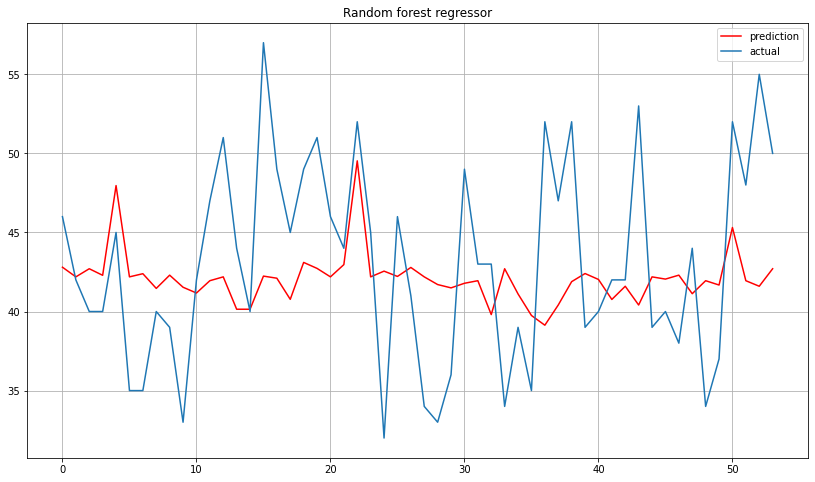

In [107]:
best_tree = tree_grid.best_estimator_
prediction = best_tree.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Random forest regressor")
plt.grid(True)

Тут картинка поинтереснее: случайный лес хорошо попал в 2 пика исходного ряда. Но в остальном так же далек от исходных данных, как и модель  линейной регрессии